
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



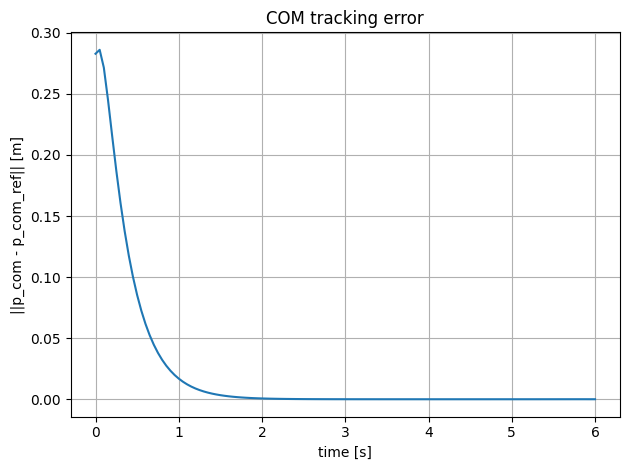

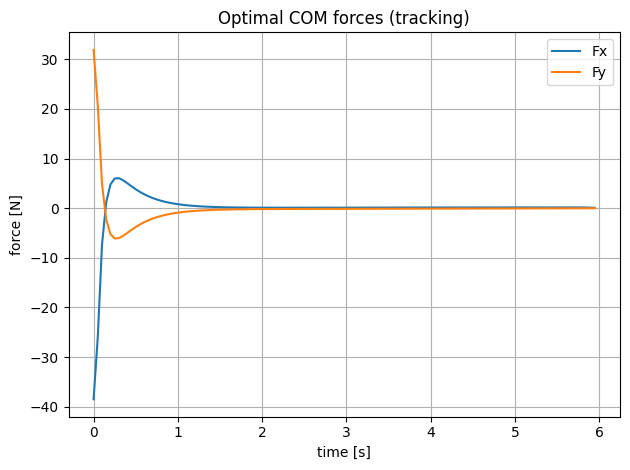

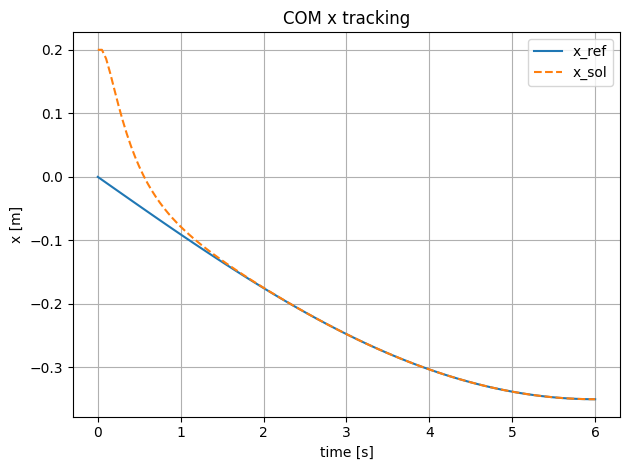

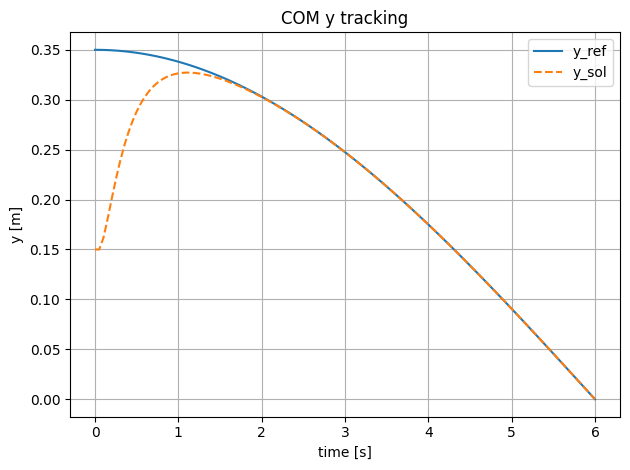

In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# PARAMETERS
dt = 0.05
N = 120
m = 7.0
a = 0.40
b = 0.30
u_max = 50.0

# Optional gravity (set to 0 if not wanted)
g = 0.0  # e.g. 9.81 if you want gravity

# Wall pivot and schedule
p_pivot = np.array([0.0, 0.0])
theta_w0 = np.pi/2
theta_wT = np.pi
T = N*dt
theta_w_dot = (theta_wT - theta_w0)/T
theta_w = np.array([theta_w0 + (k*dt)*theta_w_dot for k in range(N+1)])

# -------------------------
# "WELD" REFERENCE DEFINITION (perfectly stuck)
# Choose attachment point on the box: middle of LEFT face in COM frame
# In the box COM frame (theta=0): left face is at x=-a/2, middle is y=0
r_attach_com = np.array([-a/2, 0.0])

# Choose the wall material point distance s0 along the wall tangent from pivot.
# If you want the initial corner at pivot and theta0=0, the initial contact point is (0, b/2),
# and for a vertical wall t0=(0,1), s0 = b/2 makes the contact point match initially.
s0 = b/2

# Orientation offset between wall and box (0 => box angle equals wall angle)
theta_offset = 0.0

def rot2_np(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s],
                     [s,  c]])

def wall_t_np(theta_wk):
    return np.array([np.cos(theta_wk), np.sin(theta_wk)])

# Build reference trajectories
theta_ref = theta_w + theta_offset

p_com_ref = np.zeros((2, N+1))
for k in range(N+1):
    t_k = wall_t_np(theta_w[k])
    p_attach_wall = p_pivot + s0 * t_k             # material point on the wall
    Rk = rot2_np(theta_ref[k])
    p_com_ref[:, k] = p_attach_wall - Rk @ r_attach_com

# Reference velocities/accelerations by finite differences
v_ref = np.zeros((2, N+1))
a_ref = np.zeros((2, N))  # (2,N)
for k in range(N):
    v_ref[:, k] = (p_com_ref[:, k+1] - p_com_ref[:, k]) / dt
v_ref[:, N] = v_ref[:, N-1]

for k in range(N):
    a_ref[:, k] = (v_ref[:, k+1] - v_ref[:, k]) / dt

# -------------------------
# OPTI: track p_com_ref and v_ref with minimal effort
opti = ca.Opti()

Pcom = opti.variable(2, N+1)  # COM position
Vcom = opti.variable(2, N+1)  # COM velocity
U    = opti.variable(2, N)    # COM force

# Weights (tune)
w_p = 1e3
w_v = 1e2
w_u = 1e-2
w_term = 1e4

# Initial condition
# If you want corner at pivot and theta0=0, then COM starts at (a/2, b/2).
p_com0 = np.array([a/2, b/2])
v0 = np.array([0.0, 0.0])

opti.subject_to(Pcom[:, 0] == p_com0)
opti.subject_to(Vcom[:, 0] == v0)

# Dynamics + constraints + cost
J = 0
for k in range(N):
    pk = Pcom[:, k]
    vk = Vcom[:, k]
    uk = U[:, k]

    # Discrete dynamics
    opti.subject_to(Pcom[:, k+1] == pk + dt*vk)

    # acceleration = (U + gravity)/m
    grav = ca.vertcat(0, -m*g)
    opti.subject_to(Vcom[:, k+1] == vk + dt*(uk + grav)/m)

    # Effort limit
    opti.subject_to(ca.sumsqr(uk) <= u_max**2)

    # Tracking cost (running)
    pref_k = ca.DM(p_com_ref[:, k])
    vref_k = ca.DM(v_ref[:, k])
    J += w_p*ca.sumsqr(pk - pref_k) + w_v*ca.sumsqr(vk - vref_k) + w_u*ca.sumsqr(uk)

# Terminal tracking (strong)
pref_N = ca.DM(p_com_ref[:, N])
vref_N = ca.DM(v_ref[:, N])
J += w_term*ca.sumsqr(Pcom[:, N] - pref_N) + w_term*0.1*ca.sumsqr(Vcom[:, N] - vref_N)

opti.minimize(J)

# Initial guess (helpful)
opti.set_initial(Pcom, p_com_ref)
opti.set_initial(Vcom, v_ref[:, :])
# A good first guess for U is m*a_ref (plus gravity)
U_init = m*a_ref.copy()
U_init[1, :] += -m*g
opti.set_initial(U, U_init)

# Solve
opts = {"ipopt.print_level": 0, "print_time": 0, "ipopt.max_iter": 2000}
opti.solver("ipopt", opts)

sol = opti.solve()

# -------------------------
# Extract solution
P_sol = sol.value(Pcom)
V_sol = sol.value(Vcom)
U_sol = sol.value(U)

tgridN = np.arange(N+1)*dt
tgrid  = np.arange(N)*dt

# Plot: tracking error
err = np.linalg.norm(P_sol - p_com_ref, axis=0)

plt.figure()
plt.plot(tgridN, err)
plt.xlabel("time [s]")
plt.ylabel("||p_com - p_com_ref|| [m]")
plt.title("COM tracking error")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: forces
plt.figure()
plt.plot(tgrid, U_sol[0, :], label="Fx")
plt.plot(tgrid, U_sol[1, :], label="Fy")
plt.xlabel("time [s]")
plt.ylabel("force [N]")
plt.title("Optimal COM forces (tracking)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot: reference vs achieved COM position components
plt.figure()
plt.plot(tgridN, p_com_ref[0, :], label="x_ref")
plt.plot(tgridN, P_sol[0, :], "--", label="x_sol")
plt.xlabel("time [s]")
plt.ylabel("x [m]")
plt.title("COM x tracking")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(tgridN, p_com_ref[1, :], label="y_ref")
plt.plot(tgridN, P_sol[1, :], "--", label="y_sol")
plt.xlabel("time [s]")
plt.ylabel("y [m]")
plt.title("COM y tracking")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
